In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import corner

In [2]:
def gaussian(x, mu = 0., sigma=0.5, amp=1., offset=0.):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))+offset

In [3]:
def sine_gauss(x, a, mu, sigma, amp, offset):
    return a*np.sin(x) - gaussian(x, mu=mu, sigma=sigma, amp=amp, offset=offset)

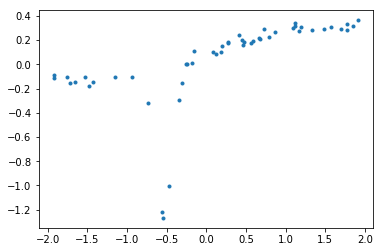

In [108]:
np.random.seed(0)
x = np.random.uniform(-2,2,50)
y = sine_gauss(x, 0.23, -0.542, 0.117, 1.2, -0.1)+np.random.uniform(-0.05,0.05,50)
plt.plot(x,y,'.')
plt.savefig('model.png')

In [5]:
truths = np.array([0.23, -0.542, 0.117, 1.2, -0.1])

In [6]:
np.savetxt('mock_data.txt', np.array([x,y]).T)   

## Parameter space exploration with Latin Hypercube sampling

To get a feel for the underlying parameter space distribution of our model, we'll run Latin Hypercube sampling with Ellert's helper function in the e13tools package and evaluate chi2 on each sample point.

In [7]:
from e13tools.sampling import lhd

We have 5 parameters and we'll generate 100 samples within large parameter ranges.

In [8]:
val_ranges = np.array([[0.,1.],[-1.,0.],[0.,0.5],[0.5,2.],[-0.5,0.5]])

In [9]:
samples = lhd(10000, 5, val_rng=val_ranges)

Let's evaluate the model in our sample points:

In [10]:
fevals = sine_gauss(x[:,np.newaxis], samples[:,0], samples[:,1], samples[:,2], samples[:,3], samples[:,4]).T

In [11]:
chi2 = 0.5*np.sum((fevals - y)**2/0.05**2, axis=1)

In [12]:
chi2.shape

(10000,)

This step isn't meant to fit the model, just give us a feel of the initial points to choose to initialize the minimizers, or the ranges to sample in.

In [13]:
# TODO: figure out a smart way to plot this in one plot and help the user choose the "interesting" regions

## Minimizers

In [16]:
def f2min(params, x):
    if params.ndim == 1:
        a, mu, sigma, amp, offset = params
        singaussf = sine_gauss(x, a, mu, sigma, amp, offset)
    
    # This logic is necessary for the way pyswarms handles function evaluation
    else:
        a, mu, sigma, amp, offset = params[:,0], params[:,1], params[:,2], params[:,3], params[:,4]
        x = x[:, np.newaxis]
        singaussf = sine_gauss(x, a, mu, sigma, amp, offset).T
    
    return 0.5*np.sum((singaussf-y)**2/0.05**2)

### scipy.optimize

In [17]:
from scipy.optimize import minimize


x0 = np.array([0., 0., 0., 1., 0.])
res = minimize(f2min, x0, args=(x,), method='Nelder-Mead')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [18]:
result_nm = res.x

### differential evolution

In [19]:
from scipy.optimize import differential_evolution as de

res_de = de(f2min, bounds = [(0.,1.),(-1.,0.),(0.,0.5),(0.5,2.),(-0.5,0.5)], args=(x,))

In [20]:
result_de = res_de.x

### pyswarms

In [21]:
from pyswarms.single.global_best import GlobalBestPSO

# instatiate the optimizer
x_min = np.array([0.,-1.,0.,0.5,-0.5])
x_max = np.array([1.,0.,0.5,2.,0.5])
bounds = (x_min, x_max)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=100, dimensions=5, options=options, bounds=bounds)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(f2min, 10000, x=x)

2019-08-02 12:00:37,336 - pyswarms.single.global_best - INFO - Optimize for 10000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10000/10000, best_cost=7.1e+04
2019-08-02 12:01:16,782 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70988.98658004586, best pos: [ 0.00366719 -0.60229286  0.29620009  0.84950371 -0.02849449]


In [81]:
result_pso = pos

PySwarms doesn't perform as well off the shelf in this case and requires much more work to get it to find the global minimum. Based on this, I assume it's most likely suited for minimizing analytical functions, but not when fitting through chi2 minimization in relatively flat and poorly constrained parameter space.

## Samplers

Let's first define the prior transform for our parameters:

In [22]:
def ptform(u):
    bounds = np.array([[0.,1.],[-1.,0.],[0.,0.5],[0.5,2.],[-0.5,0.5]])
    return (bounds[:,1]-bounds[:,0]) * u + bounds[:,0]

In [23]:
def loglike(params):
    a, mu, sigma, amp, offset = params
    singaussf = sine_gauss(x, a, mu, sigma, amp, offset)
    
    return -0.5*np.sum((singaussf-y)**2/0.05**2)

### nestle

In [24]:
import nestle

In [27]:
res = nestle.sample(loglike, ptform, 5, npoints=2000, method='single',
                    update_interval=20, maxiter=20000)
print(res.summary())

niter: 20001
ncall: 169189
nsamples: 22000
logz: -25.377 +/-  0.090
h: 16.202


2019-08-02 12:27:26,699 - root - WARNING - Too few points to create valid contours
2019-08-02 12:27:46,666 - root - WARNING - Too few points to create valid contours
2019-08-02 12:27:53,561 - root - WARNING - Too few points to create valid contours
2019-08-02 12:28:00,603 - root - WARNING - Too few points to create valid contours
2019-08-02 12:28:11,803 - root - WARNING - Too few points to create valid contours
2019-08-02 12:28:19,978 - root - WARNING - Too few points to create valid contours
2019-08-02 12:28:26,808 - root - WARNING - Too few points to create valid contours
2019-08-02 12:28:34,172 - root - WARNING - Too few points to create valid contours
2019-08-02 12:28:41,606 - root - WARNING - Too few points to create valid contours
2019-08-02 12:28:48,924 - root - WARNING - Too few points to create valid contours


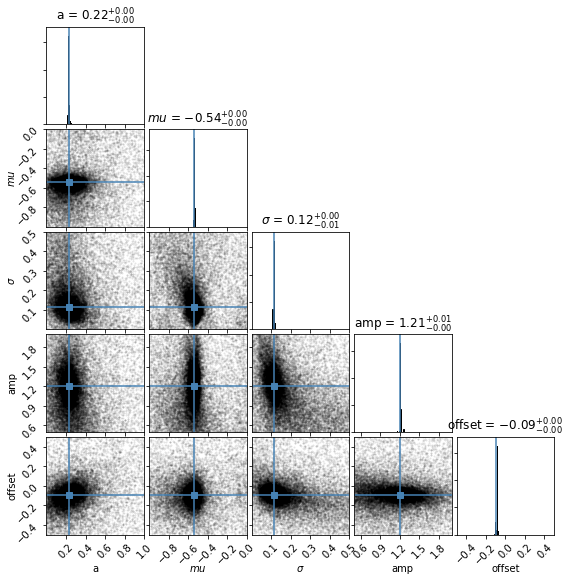

In [62]:
fig = corner.corner(res.samples, weights=res.weights, bins=500, labels=["a", "$mu$", "$\sigma$", "amp", "offset"],
                      truths=truths, show_titles=True)
fig.set_size_inches(8., 8.)

In [72]:
results_nestle = np.array([0.22, -0.54, 0.12, 1.21, -0.09])

nestle did a pretty good job at sampling the region around the true parameter values. It's slow and it might require much longer to run to produce valid contours, but it's a good start if you're unsure of where to initialize the walkers in MCMC.

### dynesty

In [53]:
import dynesty as dn
from dynesty import plotting as dyplot

In [56]:
ndim = 5

# "Dynamic" nested sampling.
dsampler = dn.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested(maxiter=20000)
dresults = dsampler.results

iter: 20000 | batch: 6 | bound: 67 | nc: 1 | ncall: 66069 | eff(%): 30.271 | loglstar: -13.944 < -7.861 < -9.629 | logz: -25.850 +/-  0.245 | stop:    nan                                            


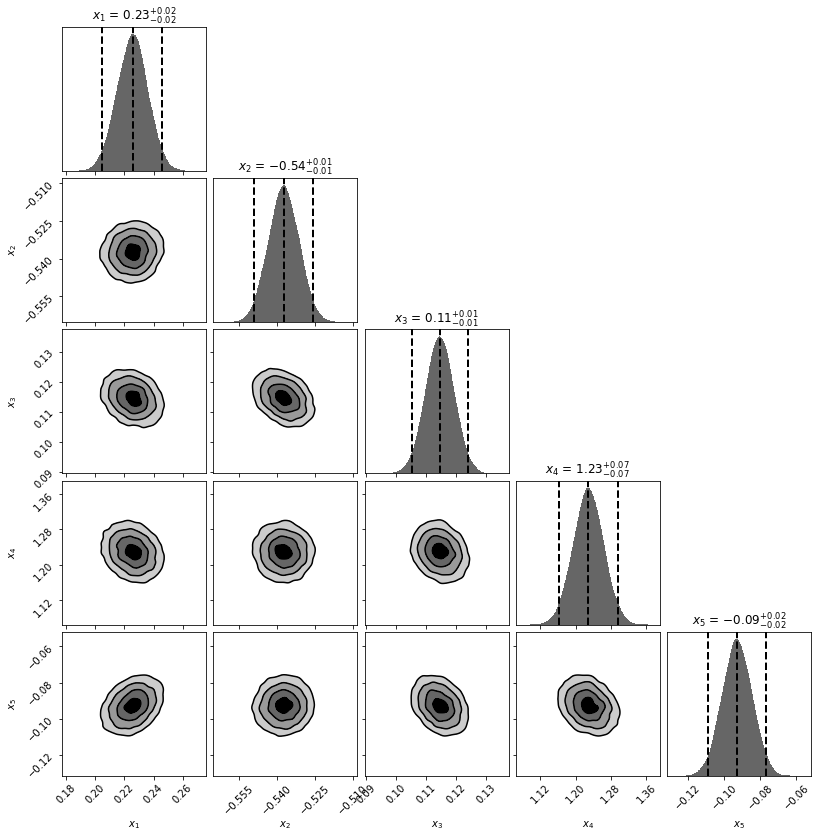

In [61]:
cdfig, cdaxes = dyplot.cornerplot(dresults, show_titles=True)

In [71]:
results_dn = np.array([0.23, -0.54, 0.11, 1.23, -0.09])

### emcee

In [48]:
import emcee

In [49]:
ndim, nwalkers = 5, 100
bounds = np.array([[0.,1.],[-1.,0.],[0.,0.5],[0.5,2.],[-0.5,0.5]])
p0 = np.array([np.random.uniform(bounds[i][0], bounds[i][1], nwalkers) for i in range(len(bounds))]).T

In [50]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike)
sampler.run_mcmc(p0, 20000)

(array([[ 2.33775184e-01, -5.35010051e-01,  1.15728995e-01,
          1.17103112e+00, -9.03940490e-02],
        [ 4.45958827e-01,  6.35996606e-01,  2.22727717e-01,
          4.97900436e-02,  3.32324309e-02],
        [ 2.31615403e-01, -5.34684659e-01,  1.13284758e-01,
          1.21619134e+00, -7.23602901e-02],
        [ 2.26204364e-01, -5.39669280e-01,  1.13083850e-01,
          1.27714459e+00, -9.10509181e-02],
        [ 2.40745233e-01, -5.40642626e-01,  1.15834177e-01,
          1.20707110e+00, -8.28960495e-02],
        [ 2.06929795e-01, -5.38687750e-01,  1.20296985e-01,
          1.20772039e+00, -9.70471387e-02],
        [ 2.29316211e-01, -5.35383065e-01,  1.14571504e-01,
          1.29525241e+00, -1.05676229e-01],
        [ 2.22389897e-01, -5.37836062e-01,  1.18475979e-01,
          1.22331108e+00, -8.64598313e-02],
        [ 2.42221984e-01, -5.40005033e-01,  1.08754421e-01,
          1.21819291e+00, -9.28856611e-02],
        [ 2.24348723e-01, -5.32855659e-01,  1.16629341e-01,
    

2019-08-02 12:29:58,972 - root - WARNING - Too few points to create valid contours
2019-08-02 12:29:59,216 - root - WARNING - Too few points to create valid contours
2019-08-02 12:29:59,402 - root - WARNING - Too few points to create valid contours
2019-08-02 12:29:59,629 - root - WARNING - Too few points to create valid contours
2019-08-02 12:29:59,815 - root - WARNING - Too few points to create valid contours
2019-08-02 12:30:00,003 - root - WARNING - Too few points to create valid contours
2019-08-02 12:30:00,416 - root - WARNING - Too few points to create valid contours
2019-08-02 12:30:00,618 - root - WARNING - Too few points to create valid contours
2019-08-02 12:30:00,805 - root - WARNING - Too few points to create valid contours


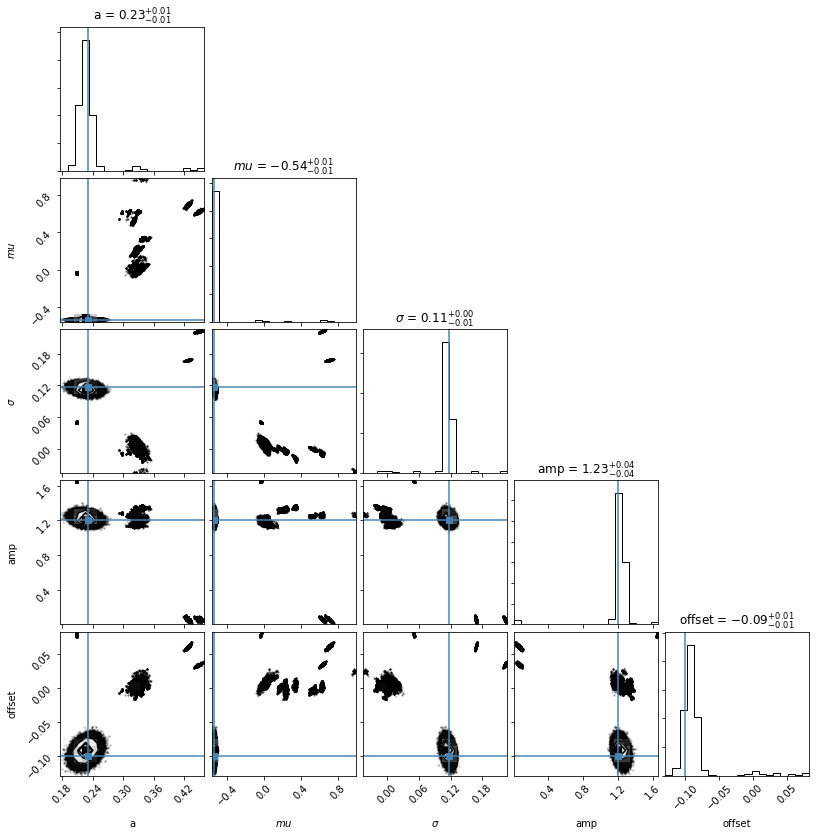

In [63]:
samples = sampler.chain[:, 10000:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "$mu$", "$\sigma$", "amp", "offset"],
                      truths=truths, show_titles=True)

In [73]:
results_emcee = np.array([0.23, -0.54, 0.11, 1.23, -0.09])

# PLOT ALL RESULTS

In [84]:
minim_results = np.vstack((result_nm, result_de, result_pso))
sampler_results = np.vstack((results_nestle, results_dn, results_emcee))

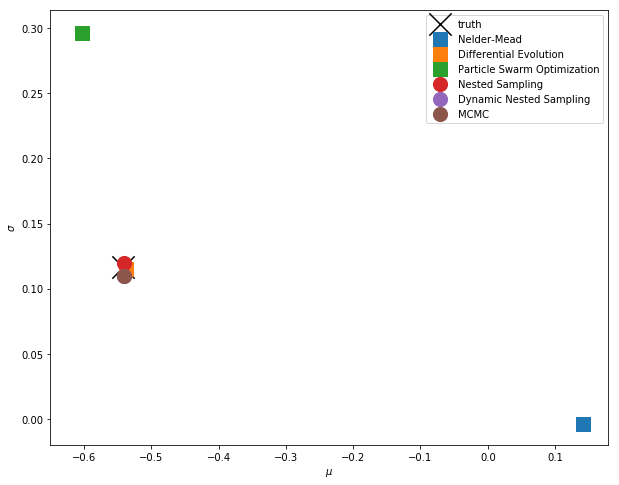

In [107]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(truths[1], truths[2], marker='x', s=500, c='k', label='truth')
ax.scatter(result_nm[1], result_nm[2], marker='s', s=200, label='Nelder-Mead')
ax.scatter(result_de[1], result_de[2], marker='s', s=200, label='Differential Evolution')
ax.scatter(result_pso[1], result_pso[2], marker='s', s=200, label='Particle Swarm Optimization')
ax.scatter(results_nestle[1], results_nestle[2], s=200, label='Nested Sampling')
ax.scatter(results_dn[1], results_dn[2], s=200, label='Dynamic Nested Sampling')
ax.scatter(results_emcee[1], results_emcee[2], s=200, label='MCMC')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
plt.legend()
plt.savefig('comparison.png')
plt.show()